#### Imports

In [11]:
import json
import os

def add_iscrowd(path):

    with open(path, 'r') as f:
        data = json.load(f)

    for i, annot in enumerate(data['annotations']):
        annot['iscrowd'] = 0
        data['annotations'][i] = annot

    with open(path, 'w') as outfile:
        json.dump(data, outfile)

base = "../datasets"

for ds in ['duke_train', 'duke_val', 'manual_maxar_val', 'fake_maxar_train', 'fake_maxar_val']:
    path = os.path.join(base, ds, 'labels.json')
    print(path)
    add_iscrowd(path)

../datasets/duke_train/labels.json
../datasets/duke_val/labels.json
../datasets/manual_maxar_val/labels.json
../datasets/fake_maxar_train/labels.json
../datasets/fake_maxar_val/labels.json


In [3]:
# torch
import torch
import torchvision

# Detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# Common Libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
# from google.colab.patches import cv2_imshow

# Detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances

#### Register and check datasets

In [4]:
os.chdir(os.path.join(os.getcwd(), '..', 'datasets'))

In [12]:
from itertools import product

for d, ds in product(["train", "val"], ['fake_maxar' 'duke']):
    ds_path = os.path.join(os.getcwd(), f'{ds}_{d}', 'data')
    json_path = os.path.join(os.getcwd(), f'{ds}_{d}', 'labels.json')
    ds_name = f'{ds}_{d}'

    if ds_name in DatasetCatalog.list():
        DatasetCatalog.remove(ds_name)
        MetadataCatalog.remove(ds_name)

    register_coco_instances(ds_name, {}, json_path, ds_path)


ds_name = 'manual_maxar_val'   
ds_path = os.path.join(os.getcwd(), f'{ds_name}', 'data')
json_path = os.path.join(os.getcwd(), f'{ds_name}', 'labels.json')

if ds_name in DatasetCatalog.list():
    DatasetCatalog.remove(ds_name)
    MetadataCatalog.remove(ds_name)

register_coco_instances(ds_name, {}, json_path, ds_path)

In [6]:
train_dataset = 'duke_train'
val_dataset = 'duke_val'
train_metadata = MetadataCatalog.get(train_dataset)
val_metadata = MetadataCatalog.get(val_dataset)

WARNING [02/25 16:25:41 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[02/25 16:25:41 d2.data.datasets.coco]: Loaded 11813 images in COCO format from /disk3/fioriti/git/detect_energy/cluster-runs/datasets/duke_train/labels.json


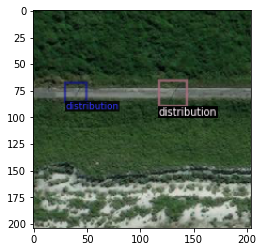

In [13]:
%matplotlib inline
dataset_dicts = DatasetCatalog.get(train_dataset)
tower_metadata = MetadataCatalog.get(train_dataset)

num_examples = 5
for d in random.sample(dataset_dicts, num_examples):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=tower_metadata, scale=0.8, instance_mode=1)
    out = visualizer.draw_dataset_dict(d)
    # cv2.imshow(out.get_image()[:, :, ::-1])
    plt.imshow(out.get_image()[:, :, ::])

#### Setup training config

In [8]:
!nvidia-smi

Fri Feb 25 16:20:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:01:00.0 Off |                    0 |
| N/A   57C    P0   304W / 400W |   7068MiB / 40536MiB |     99%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM...  On   | 00000000:41:00.0 Off |                    0 |
| N/A   

In [22]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator
from detectron2.evaluation import inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.data import DatasetMapper

from datetime import date


class EvalTrainer(DefaultTrainer):
    def __init__(self, cfg):
        super().__init__(cfg)

        self.same_data_loader = build_detection_test_loader(DatasetCatalog.get(cfg.DATASETS.TEST1),
                                                            mapper=DatasetMapper(cfg, is_train=False))
        self.same_data_eval = COCOEvaluator(cfg.DATASETS.TEST1)
        self.manual_maxar_loader = build_detection_test_loader(DatasetCatalog.get(cfg.DATASETS.TEST2),
                                                            mapper=DatasetMapper(cfg, is_train=False))
        self.manual_maxar_eval = COCOEvaluator(cfg.DATASETS.TEST2)


    def after_step(self):
        super().after_step()

        if self.iter % self.cfg.TEST.INTERVAL == 0:                                   

            results = inference_on_dataset(self.model, 
                                                     self.manual_maxar_loader,
                                                     self.manual_maxar_eval)

            with open(
                os.path.join(
                    self.cfg.OUTPUT_DIR,
                    'eval_manualsdata_'+str(self.cfg.DATASETS.TRAIN)+'_iter_'+str(self.iter)+'.json'), 
                    'w') as out:
                json.dump(results, out)   
            
            same_data_results = inference_on_dataset(self.model, 
                                                     self.same_data_loader,
                                                     self.same_data_eval)


            with open(
                os.path.join(
                    self.cfg.OUTPUT_DIR,
                    'eval_samedata_'+str(self.cfg.DATASETS.TRAIN)+'_iter_'+str(self.iter)+'.json'),
                    'w') as out:
                json.dump(same_data_results, out)                                

            


def do_train(train_dataset='duke'):

    cfg = get_cfg()

    frcnn= 'faster_rcnn_R_101_FPN_3x.yaml'

    # From Detectron2 Model Zoo
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/"+frcnn))
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/"+frcnn)

    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2   # for R-CNN Models

    cfg.defrost()
    cfg.DATASETS.TRAIN = (train_dataset+'_train')
    cfg.DATASETS.TEST1 = (train_dataset+'_val')
    cfg.DATASETS.TEST2 = ('manual_maxar_val')
    cfg.TEST.INTERVAL = 10_000
    cfg.SOLVER.MAX_ITER = 2_000_000
    cfg.SOLVER.STEPS = (500_000, 1_000_000, 1_500_000)

    model_name = "PISA_" + str(date.today()) + '_' + train_dataset
    cfg.OUTPUT_DIR = '../models/' + model_name

    cfg.freeze()

    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    trainer = EvalTrainer(cfg) 
    trainer.resume_or_load(resume=False)

    trainer.train()


for ds in ['duke', 'fake_maxar']:
    do_train(ds)


[02/25 16:35:37 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, we

[02/25 16:35:58 d2.engine.train_loop]: Starting training from iteration 0
[02/25 16:35:59 d2.evaluation.evaluator]: Start inference on 855 batches
[02/25 16:36:00 d2.evaluation.evaluator]: Inference done 11/855. Dataloading: 0.0102 s/iter. Inference: 0.0282 s/iter. Eval: 0.0005 s/iter. Total: 0.0390 s/iter. ETA=0:00:32
[02/25 16:36:05 d2.evaluation.evaluator]: Inference done 134/855. Dataloading: 0.0104 s/iter. Inference: 0.0296 s/iter. Eval: 0.0006 s/iter. Total: 0.0406 s/iter. ETA=0:00:29
[02/25 16:36:10 d2.evaluation.evaluator]: Inference done 260/855. Dataloading: 0.0102 s/iter. Inference: 0.0293 s/iter. Eval: 0.0006 s/iter. Total: 0.0402 s/iter. ETA=0:00:23
[02/25 16:36:15 d2.evaluation.evaluator]: Inference done 384/855. Dataloading: 0.0102 s/iter. Inference: 0.0295 s/iter. Eval: 0.0006 s/iter. Total: 0.0403 s/iter. ETA=0:00:18
[02/25 16:36:20 d2.evaluation.evaluator]: Inference done 497/855. Dataloading: 0.0101 s/iter. Inference: 0.0306 s/iter. Eval: 0.0005 s/iter. Total: 0.0413

KeyboardInterrupt: 